In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Import helper functions
import pre_proc_func as ppf
from params import *
from plots import note_distribution, inter_note_distribution
from stats_plotter import note_stats_master, note_stats_file
from dimensionality_analysis import pca_analysis, umap_analysis, lda_analysis
from classifiers import logreg, dtc, rtf
from geo_codes import geo_distance
import geopandas as gpd
from shapely.geometry import Point

sns.set_theme(style="whitegrid")


%load_ext autoreload
%autoreload 2

In [2]:
ppf.screen_tables(species_list)

palmarum
pennanti
tristriatus
sublineatus
No errors reported, you are good to go!


In [3]:
# Load Location File
location_path = os.path.join(PROJECT_PATH, 'locations_new.csv')
location_df = pd.read_csv(location_path)
# Add extension to file names wherever needed
for i in range(location_df.shape[0]):
    if location_df.loc[i, '12_Audio_file_name'][-4:] != '.wav' and location_df.loc[i, '12_Audio_file_name'][-4:] != '.WAV':
        #print(location_df.loc[i, '12_Audio_file_name'])
        location_df.loc[i, '12_Audio_file_name'] = location_df.loc[i, '12_Audio_file_name'] + '.wav'

In [4]:
# Create master_df by concatenating all files
df_folder = os.path.join(PROJECT_PATH, 'dataframes')
if not os.path.exists(df_folder):
    os.mkdir(df_folder)

if not os.path.exists(os.path.join(df_folder, 'master_df.csv')):
    print('Creating master_df')
    master_df = ppf.generate_master_df(species_list, location_df)
    master_good_df = master_df[master_df['Quality'] == 'G']

    master_df.to_csv(os.path.join(df_folder, 'master_df.csv'), index = False)
    master_good_df.to_csv(os.path.join(df_folder, 'master_good_df.csv'), index = False)
else:
    print('Reading in existing master_df and master_good_df')
    master_df = pd.read_csv(os.path.join(df_folder, 'master_df.csv'))
    master_good_df = pd.read_csv(os.path.join(df_folder, 'master_good_df.csv'))

# Create a summary_df for all the files
print()
if not os.path.exists(os.path.join(df_folder, 'summary_df.csv')):
    print('Creating summary_df')
    df_by_species = master_df.groupby('Species')
    df_by_species_good = master_df[master_df['Quality'] == 'G'].groupby('Species')
    summary_df_1 = df_by_species.agg({'File_name': 'nunique', 'Note': ['count', 'nunique']})
    summary_df_1.columns = ['_'.join(col) for col in summary_df_1.columns]
    summary_df_2 = df_by_species_good.agg({'Note': ['count','nunique']})
    summary_df_2.columns = ['_good_'.join(col) for col in summary_df_2.columns]
    summary_df = summary_df_1.join(summary_df_2)
    summary_df.to_csv(os.path.join(df_folder, 'summary_df.csv'))
else:
    print('Reading in existing summary_df')
    summary_df = pd.read_csv(os.path.join(df_folder, 'summary_df.csv'))

# Create a dataframe with random sampling of notes from each file
print()
if not os.path.exists(os.path.join(df_folder, 'master_random_df.csv')):
    print('Creating randomly sampled dataframe')
    master_random_df = pd.DataFrame()
    beg_file = master_good_df['File_name'].unique()
    for bf in beg_file:
        sp_df = master_good_df[master_good_df['File_name'] == bf]
        threshold_value = sample_threshold_dict[sp_df['Species'].unique()[0]]
        #print(threshold_dict[sp_df['species'].unique()[0]])
        if sp_df.shape[0] > threshold_value:
            sp_df = sp_df.sample(threshold_value, random_state = 42)
        master_random_df = pd.concat([master_random_df, sp_df], ignore_index = True)
    master_random_df.to_csv(os.path.join(df_folder, 'master_random_df.csv'), index = False)
else:
    print('Reading in existing randomly sampled dataframe')
    master_random_df = pd.read_csv(os.path.join(df_folder, 'master_random_df.csv'))

if not os.path.exists(os.path.join(df_folder, 'file_df.csv')):
    print('Creating file dataframes')

    file_df = ppf.generate_file_df(master_df, location_df)
    file_good_df = ppf.generate_file_df(master_good_df, location_df)
    file_random_df = ppf.generate_file_df(master_random_df, location_df)

    file_df.to_csv(os.path.join(df_folder, 'file_df.csv'), index = False)
    file_good_df.to_csv(os.path.join(df_folder, 'file_good_df.csv'), index = False)
    file_random_df.to_csv(os.path.join(df_folder, 'file_random_df.csv'), index = False)
else:
    print('Reading in existing file dataframes')
    file_df = pd.read_csv(os.path.join(df_folder, 'file_df.csv'))
    file_good_df = pd.read_csv(os.path.join(df_folder, 'file_good_df.csv'))
    file_random_df = pd.read_csv(os.path.join(df_folder, 'file_random_df.csv'))

Reading in existing master_df and master_good_df

Reading in existing summary_df

Reading in existing randomly sampled dataframe
Reading in existing file dataframes


In [5]:
# Create a table summarizing number of files per species
file_df_by_species = file_df.groupby('Species')
print(file_df_by_species['File_name'].nunique())

# Create a table summarizing number of files per location and species
file_df_by_location_species = file_df.groupby(['Species', 'Location'])
print(file_df_by_location_species['File_name'].nunique())

Species
F. palmarum       167
F. pennanti        82
F. sublineatus      9
F. tristriatus    144
Name: File_name, dtype: int64
Species         Location      
F. palmarum     B R Hills          1
                Bengaluru         28
                Chennai           25
                Colombo           31
                Kodaikanal        20
                Kotagiri           3
                Mettupalayam      16
                Ottapalam         13
                Tirupati          14
                Tiruvannamalai     1
                Vijayawada        15
F. pennanti     Chandigarh        18
                Jalgaon            1
                Jodhpur           12
                Kolkata            2
                Lucknow            5
                New Delhi         28
                Pune              16
F. sublineatus  Kodaikanal         9
F. tristriatus  Annamalai          7
                Goa               28
                Kozhikode          1
                Malappuram   

In [8]:
# Get a description of different note-types for each species
master_df_notes_by_species = master_df.groupby(['Species', 'Note'])
# Sort in descending order for each species
for species in species_list:
    
    count_of_notes = master_df[(master_df['Species'] == 'F. '+ species) & (master_df['Quality'] == 'G')]['Note'].value_counts(normalize=True)
    # Get a count of file for each note
    unique_notes = master_df[(master_df['Species'] == 'F. '+ species) & (master_df['Quality'] == 'G')]['Note'].unique()
    print(species + ' Unique notes: ', len(unique_notes))
    note_count_df = pd.DataFrame(columns = ['Note', 'Note proportion', 'File count'])
    for note in unique_notes:
        note_count_df = note_count_df.append({'Note': note, 'Note proportion': round(count_of_notes[note]*100, 4), 'File count': master_df[(master_df['Species'] == 'F. '+ species) & (master_df['Quality'] == 'G') & (master_df['Note'] == note)]['File_name'].nunique()}, ignore_index = True)

    print(note_count_df.sort_values(by = 'Note proportion', ascending = False))

    
    # print(count_of_notes * 100)

    # print(master_df[master_df['Species'] == 'F. '+ species]['Note'].value_counts()) #.sort_values(by = 'Note', ascending = False))

    # print(file_df[file_df['Species'] == 'F. '+ species]['Note'].value_counts()) #.sort_values(by = 'Note', ascending = False)
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(master_df_notes_by_species['File_name'].nunique())
# display(master_df_notes_by_species['File_name'].nunique().to_string())

palmarum Unique notes:  22
         Note  Note proportion File count
0          IU          42.0628        142
1       IU-RD          25.0192        118
2       IU-LD          15.5784         85
3           P           5.5722         46
5           T           3.2687         36
6           S           2.4227         15
4          RD           2.2189         41
10        lIU           0.9960         20
8      lIU-LD           0.6191         13
19   IU-RD-LE           0.4730          1
17   IU-RD-RE           0.4461          3
16   IU-LD-RE           0.3769          4
13         lP           0.1923          1
7      lIU-RD           0.1884         12
9        llIU           0.1692          4
18          W           0.1500          4
15         LD           0.1423          7
20      IU-RE           0.0385          1
14        lRD           0.0385          1
12        lX3           0.0154          1
11    llIU-LD           0.0077          2
21  lIU-LD-RE           0.0038          1
pennant

In [6]:
master_df.columns

Index(['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)',
       'Low Freq (Hz)', 'High Freq (Hz)', 'Begin File', 'Begin Path',
       'End File',
       ...
       'BuiltSettlement2019', 'BuiltSettlement2020', 'Nightlight2019',
       'ForestCanopy2019', 'NDVI', 'Tmean', 'Pmean', 'Tmax', 'Tmin',
       'TempSeasonailty'],
      dtype='object', length=107)

In [7]:
print("Running preliminary analysis")
print("Saving note distribution")
note_distribution(master_good_df, species_list)

master_df_bout_version = pd.DataFrame()
for bf in master_df['File_name'].unique():
   temp_df = master_df[master_df['File_name'] == bf].reset_index(drop = True)
   temp_df = temp_df.drop([0]).reset_index(drop = True)
   master_df_bout_version = pd.concat([master_df_bout_version, temp_df])

for spp in master_df_bout_version['Species'].unique():
    bout_df_temp = master_df_bout_version[master_df_bout_version['Species'] == spp]
    bout_df_temp = bout_df_temp[bout_df_temp['Inter_note_difference (s)'] > sub_bout_difference_dict_F[spp]]
    print(spp, bout_df_temp['Inter_note_difference (s)'].min())
    Q1, M, Q3 = bout_df_temp[bout_df_temp['Species'] == spp]['Inter_note_difference (s)'].quantile([0.25, 0.5, 0.75])
    IQR = Q3 - Q1
    LB = Q1 - 1.5 * IQR
    UB = Q3 + 1.5 * IQR
    print(Q1, M, Q3)
    print(IQR)
    print(LB, UB)
    print()
print("Saving internote distribution")
inter_note_distribution(species_list, master_df_bout_version)

Running preliminary analysis
Saving note distribution
F. palmarum 0.15004984999999493
0.29617286900000295 0.372034192000001 0.49602792000000306
0.19985505100000012
-0.003609707499997228 0.7958104965000032

F. pennanti 0.10025111699999911
0.4030511150000109 0.5217679600000054 0.7024911159999974
0.29944000099998647
-0.046108886499968804 1.151651117499977

F. tristriatus 0.15006698799999985
0.2929505480000003 0.3813751579999973 0.4919854650000026
0.1990349170000023
-0.005601827500003154 0.7905378405000061

F. sublineatus 0.10001977999999667
0.27222872499999884 0.5608435940000023 1.0030321575000034
0.7308034325000046
-0.823976423750008 2.0992373062500103

Saving internote distribution


In [7]:
cols_to_consider = ['Species', 'Location', 'Median Low Freq (Hz)', 'Median High Freq (Hz)',
       'Median Delta Freq (Hz)', 'Median Delta Time (s)',
       'Median Inter_note_difference (s)', 'Note density (notes per s)',
       'Sub-bout density (sub-bouts per s)', 'Bout density (bouts per s)',
       'Unique note count']
cols_to_consider_blurb = ['Median Low Freq (Hz)', 'Median High Freq (Hz)',
       'Median Delta Freq (Hz)', 'Median Delta Time (s)',
       'Median Inter_note_difference (s)', 'Note density (notes per s)',
       'Sub-bout density (sub-bouts per s)', 'Bout density (bouts per s)',
       'Unique note count']
#file_random_df = pd.read_csv(os.path.join(df_path, 'file_random_df.csv'))
#print(file_good_df.columns)
selected_features_notes = ['PFC Max Freq (Hz)', 'PFC Min Freq (Hz)', 'BW 90% (Hz)']
selected_features_files = ['Median Delta Freq (Hz)', 'Median High Freq (Hz)', 'Stdev High Freq (Hz)']

#df_folder = os.path.join(PROJECT_PATH, 'descriptive_stats')
df_folder = os.path.join(PROJECT_PATH, 'Figures')
if not os.path.exists(df_folder):
    os.mkdir(df_folder)

note_stats_master(master_good_df, df_folder)
note_stats_file(file_good_df, df_folder, cols_to_consider, cols_to_consider_blurb)

NOTE LEVEL ANALYSIS
Running Classifiers
Logistic Regression
Classification Report for logreg
                precision    recall  f1-score   support

   F. palmarum       0.88      0.89      0.88      1548
   F. pennanti       0.94      0.93      0.94       762
F. sublineatus       0.95      0.54      0.69       100
F. tristriatus       0.93      0.94      0.94      2935

      accuracy                           0.92      5345
     macro avg       0.92      0.83      0.86      5345
  weighted avg       0.92      0.92      0.92      5345

Confusion Matrix for logreg
[[1373    7    0  168]
 [  15  711    3   33]
 [  22   19   54    5]
 [ 156   16    0 2763]]

Decision Tree Classifier
Classification Report
                precision    recall  f1-score   support

   F. palmarum       0.92      0.92      0.92      1548
   F. pennanti       0.95      0.94      0.95       762
F. sublineatus       0.85      0.87      0.86       100
F. tristriatus       0.95      0.95      0.95      2935

     

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


explained variance ratio (first two components): [0.9048135 0.0940315]



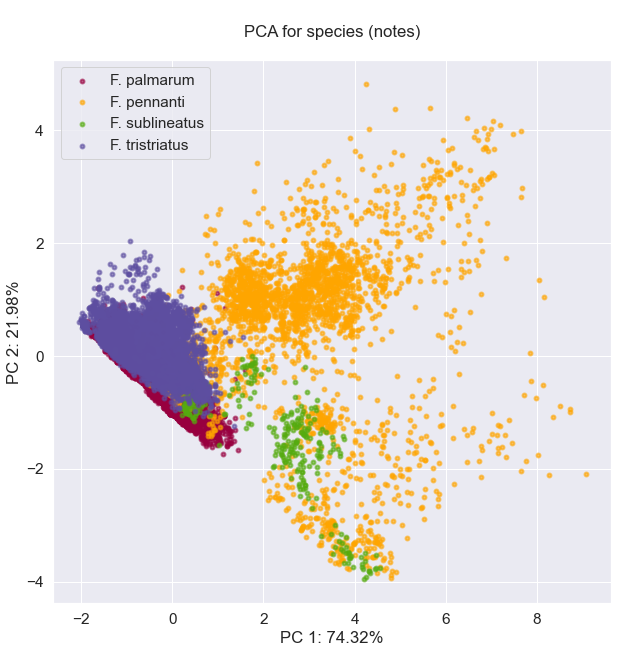

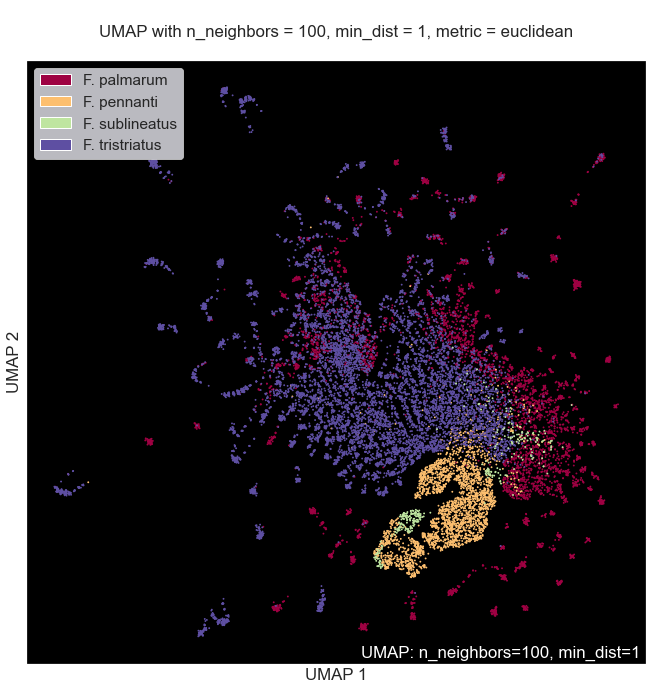

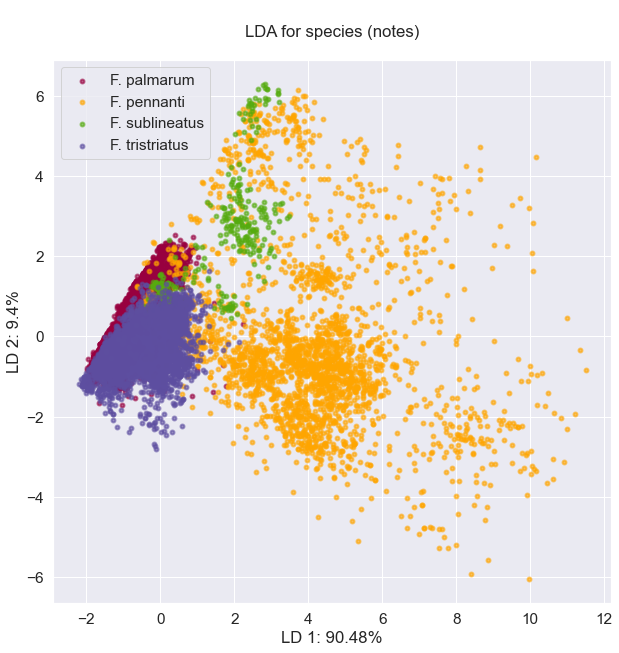

In [8]:
print('NOTE LEVEL ANALYSIS')
print('Running Classifiers')
X = master_random_df[acoustic_features]
sc = StandardScaler()
scaled_features = sc.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, index = X.index, columns = X.columns)
y = master_random_df['Species']

print('Logistic Regression')
logreg(X_scaled, y, title = 'Feature Importance Logistic Regression (notes)',
    filename = 'logistic_regression_feature_importance_notes.png')
print()

print('Decision Tree Classifier')
dtc(X_scaled, y, title = 'Feature Importance Decision Tree Classifier (notes)',
    filename = 'decision_tree_classifier_feature_importance_notes.png')
print()

print('Random Forest Classifier')
rtf(X_scaled, y, title = 'Feature Importance Random Forest Classifier (notes)',
    filename = 'random_forest_classifier_feature_importance_notes.png')
print()

print('Running PCA, UMAP, and LDA')
pca_analysis(master_random_df, X_scaled[selected_features_notes], y, title = 'PCA for species (notes)', filename = 'pca_notes.png')
umap_analysis(master_random_df, X_scaled[selected_features_notes], y, title = 'UMAP for species (notes)', filename = 'umap_notes.png')
lda_analysis(master_random_df, X_scaled[selected_features_notes], y, title = 'LDA for species (notes)', filename = 'lda_notes.png')
print()

In [11]:
map_df = gpd.read_file(os.path.join(PROJECT_PATH, 'Figures', 'Geoanalysis', 'india-polygon.shp'))

In [13]:
map_df.head(20)

,id,st_nm,geometry
0,None,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0..."
1,None,Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612..."
2,None,Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578..."
3,None,Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640..."
4,None,Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552..."
5,None,Chhattisgarh,"POLYGON ((83.94694 23.62196, 83.95594 23.62406..."
6,None,Dadra and Nagar Haveli,"POLYGON ((73.20640 20.12165, 73.20865 20.10695..."
7,None,Daman and Diu,"POLYGON ((72.80144 20.37378, 72.84418 20.47463..."
8,None,Goa,"POLYGON ((74.11982 15.65278, 74.24806 15.65698..."
9,None,Gujarat,"MULTIPOLYGON (((68.35808 23.80475, 68.41658 23..."


In [16]:
file_df['Species'].value_counts()

F. palmarum       167
F. tristriatus    144
F. pennanti        82
F. sublineatus      9
Name: Species, dtype: int64

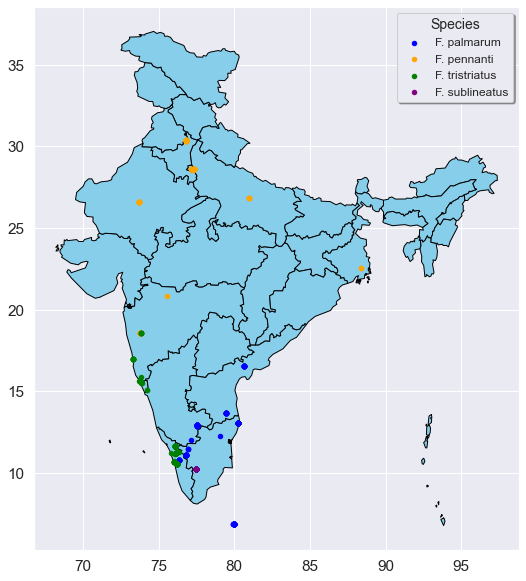

In [24]:
fig = plt.figure(figsize=(10, 10))
map_df.plot(ax = fig.gca(), color = 'skyblue', edgecolor = 'black')
msize = 20
sp_counter = [0, 0, 0, 0]
for i in range(file_df.shape[0]):
    if file_df.loc[i, 'Species'] == 'F. palmarum':
        if sp_counter[0] == 0:
            plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'blue', s = msize, label = 'F. palmarum')
            sp_counter[0] = 1
        else:
            plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'blue', s = msize)
    elif file_df.loc[i, 'Species'] == 'F. tristriatus':
        if sp_counter[1] == 0:
            plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'green', s = msize, label = 'F. tristriatus')
            sp_counter[1] = 1
        else:
            plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'green', s = msize)
    elif file_df.loc[i, 'Species'] == 'F. pennanti':
        if sp_counter[2] == 0:
            plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'orange', s = msize, label = 'F. pennanti')
            sp_counter[2] = 1
        else:
            plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'orange', s = msize)
    elif file_df.loc[i, 'Species'] == 'F. sublineatus':
        if sp_counter[3] == 0:
            plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'purple', s = msize, label = 'F. sublineatus')
            sp_counter[3] = 1
        else:
            plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'purple', s = msize)

plt.legend(loc = 'upper right', fontsize = 12, 
              title = 'Species', title_fontsize = 14, shadow = True)
plt.show()
    # plt.scatter(file_df.loc[i, 'Longitude'], file_df.loc[i, 'Latitude'], c = 'red', s = 10)